In [1]:
# Tratamiento de datos

import pandas as pd  # Manipulación y análisis de datos.
import numpy as np  # Soporte para vectores y matrices.

# Gráficos

import matplotlib.pyplot as plt  # Creación de gráficos estáticos, animados e interactivos.
from matplotlib import style  # Personalización del estilo de los gráficos.

# Preprocesado y modelado

from scipy.stats import pearsonr  # Coeficiente de correlación de Pearson.
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas para evaluar modelos.
import statsmodels.api as sm  # Modelos estadísticos y econometricos.
import statsmodels.formula.api as smf  # Modelo estadísticos con fórmulas.
from statsmodels.stats.anova import anova_lm  # Análisis de varianza.
from scipy import stats  # Funciones estadísticas.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler  # Preprocesamiento de datos.
import category_encoders  # Codificación de variables categóricas.
import missingno as msno  # Visualización de datos faltantes.
from sklearn.pipeline import Pipeline  # Cadena de transformaciones con un estimador final.
from sklearn.experimental import enable_iterative_imputer  # Permitir uso de IterativeImputer.
from sklearn.impute import IterativeImputer  # Imputación de datos faltantes.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos de ensamble.
from sklearn.model_selection import GridSearchCV, cross_val_score  # Búsqueda de hiperparámetros y validación cruzada.

# Deep Learning

import tensorflow as tf  # Biblioteca de Deep Learning.
from tensorflow.keras import layers, models  # Construcción de modelos de deep learning.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks para controlar el entrenamiento.
from keras.models import Sequential  # Creación de modelos secuenciales.
from keras.layers import Dense, Dropout, BatchNormalization  # Capas para construir modelos.
from keras import regularizers  # Regularización de modelos.

In [2]:
"""
Seguimos indagando en el modelo de Gradient Boosting e imputación de ciertas variables importantes para la predicción y que
no tenemos disponible a la hora de hacer la predicciones. Veremos que el código es casi siempre el mismo, lo único que cambiará
es que imputaremos valores a más variables del Dataset como: 'f_PREV_HIGH' y 'f_RUN'.
En este notebook vamos a utilizar un modelo de Gradient Boosting para entrenar el conjunto de datos y hacer la predicciones y también 
un modelo de Gradient Boosting para entrenar el imputador MICE. 
Cuando lleguemos a los trozos de código en que haya cambios respecto a los anteriores lo reflejaremos en los comentarios.

"""

"\nSeguimos indagando en el modelo de Gradient Boosting e imputación de ciertas variables importantes para la predicción y que\nno tenemos disponible a la hora de hacer la predicciones. Veremos que el código es casi siempre el mismo, lo único que cambiará\nes que imputaremos valores a más variables del Dataset como: 'f_PREV_HIGH' y 'f_RUN'.\nEn este notebook vamos a utilizar un modelo de Gradient Boosting para entrenar el conjunto de datos y hacer la predicciones y también \nun modelo de Gradient Boosting para entrenar el imputador MICE. \nCuando lleguemos a los trozos de código en que haya cambios respecto a los anteriores lo reflejaremos en los comentarios.\n\n"

In [3]:
# Leemos el archivo csv  con los datos.

df_central = pd.read_csv("https://raw.githubusercontent.com/jesusvillaalvarez/TFM_KSCHOL/main/5.ARCHIVOS/df_central_2_1.csv")



In [4]:
# Eliminamos columnas que no nos aportan valor como podemos ver en el archivo de estudio de las variables.

df_central.drop(['Unnamed: 0', 'f_PREV_LOW', 'DESVIO'], axis=1, inplace=True)

df_central['Fecha'] = pd.to_datetime(df_central['Fecha'])

df_central['f_RUN'] = df_central['f_RUN'].astype(bool)

# df_central.head()


In [5]:
# Dividimos df_central en dos Dataframes:
# - df_inicio que contendrá los datos de inicio hasta el 31-10-2023 que utilizaremos para entrenar los modelos de predicción
# - df_final que contendrá los datos del mes de noviembre de 2023 que uilitzaremos para hacer una simulación real de predicción
#   para ver si las predicciones del modelo mejora las previsiones.

df_inicio = df_central[df_central['Fecha'] <= '2023-10-31']
df_final = df_central[df_central['Fecha'] >= '2023-11-05']

In [6]:
# Decidimos eliminar la columna 'Fecha' ya que tenemos columnas específicas que nos marcan el día, mes y año.

df_inicio = df_inicio.drop('Fecha', axis=1)
df_final = df_final.drop('Fecha', axis=1)

In [7]:
# Excluimos la variable objetivo E_SIMEL del conjunto de entrenamiento y la marcamos como variable objetivo
# Dividimos los datos en los conjuntos de entrenamiento y prueba

X_inicio = df_inicio.drop('E_SIMEL', axis=1)  
y_inicio = df_inicio['E_SIMEL']  

X_train_inicio, X_test_inicio, y_train_inicio, y_test_inicio = train_test_split(X_inicio, y_inicio, test_size=0.2, random_state=42)


In [8]:



# Definimos el modelo de Gradient Boosting

gb_r = GradientBoostingRegressor(random_state=42)

# Definimos en qué parámetros se basará la prueba
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
    'learning_rate': [0.01, 0.1],
}

# Configuramos el  GridSearchCV para la búsqueda de los mejores Hiperparámetros

grid_search = GridSearchCV(estimator=gb_r, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Ejecutamos la búsqueda

grid_search.fit(X_train_inicio, y_train_inicio)

# Imprimimos para visualizar los Hiperparámetros y la puntuación

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)




Fitting 3 folds for each of 96 candidates, totalling 288 fits
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación: -17.579381465169


In [9]:
# Creamos el modelo de Gradient Boosting con los mejores Hiperparámetros

gb_r_optimizado = GradientBoostingRegressor(n_estimators=100, max_depth=10, learning_rate= 0.1, 
                                            max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, random_state=42)

gb_r_optimizado.fit(X_train_inicio, y_train_inicio)


GradientBoostingRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                          random_state=42)

In [10]:
# Hacemos las predicciones del conjunto de prueba y calculamos las métricas MSE y R2

y_pred_test = gb_r_optimizado.predict(X_test_inicio)

mse_test = mean_squared_error(y_test_inicio, y_pred_test)
r2_test = r2_score(y_test_inicio, y_pred_test)

print("MSE en el conjunto de prueba:", mse_test)
print("R² en el conjunto de prueba:", r2_test)


MSE en el conjunto de prueba: 14.404705794779822
R² en el conjunto de prueba: 0.9495122608122182


In [11]:
# Entrenamos un modelo de GradientBosstingRegressor para el imputador MICE

estimador_gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Creamos el imputador

mice_imputer = IterativeImputer(estimator=estimador_gb, random_state=42)

# Entrenamos el imputador con todas las columnas de df_inicio, icnluidas f_PREV_HIGH y f_RUN

mice_imputer.fit(df_inicio[['Period', 'PREVISION','f_PREV_HIGH', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])



IterativeImputer(estimator=GradientBoostingRegressor(max_depth=10,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=4,
                                                     random_state=42),
                 random_state=42)

In [12]:
"""
A partir de aquí, el proceso es igual al de los anteriores notebooks:
- Seleccionamos los datos del día que queremos predecir
- Hacemos el tratamiento para la imputación de las variables f_PREV_HIGH y f_RUN
- Procedemos a la predicción

"""

'\nA partir de aquí, el proceso es igual al de los anteriores notebooks:\n- Seleccionamos los datos del día que queremos predecir\n- Hacemos el tratamiento para la imputación de las variables f_PREV_HIGH y f_RUN\n- Procedemos a la predicción\n\n'

In [13]:

df_final_05_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]

df_final_05_11_para_imputar = df_final_05_11.drop(['E_SIMEL'], axis=1)

df_final_05_11_para_imputar[['f_PREV_HIGH','f_RUN']] = np.nan  

valores_imputados = mice_imputer.transform(df_final_05_11_para_imputar[['Period', 'PREVISION', 'f_PREV_HIGH', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])


valores_imputados_f_PREV_HIGH = valores_imputados[:, 2]  
valores_imputados_f_RUN = valores_imputados[:, 3]  


valores_imputados_f_RUN_boolean = np.where(valores_imputados_f_RUN > 0.2, True, False)
valores_imputados_f_PREV_HIGH_boolean = np.where(valores_imputados_f_PREV_HIGH > 0, True, False)


df_final_05_11.loc[df_final_05_11.index, 'f_RUN'] = valores_imputados_f_RUN_boolean
df_final_05_11.loc[df_final_05_11.index, 'f_PREV_HIGH'] = valores_imputados_f_PREV_HIGH_boolean


caracteristicas_para_prediccion = df_final_05_11.drop('E_SIMEL', axis=1) 


predicted_e_simel_05_11 = gb_r_optimizado.predict(caracteristicas_para_prediccion)

predicted_e_simel_05_11 = np.maximum(predicted_e_simel_05_11, 0)



df_predicciones_05_11 = df_final_05_11[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()
df_predicciones_05_11['predicted_E_SIMEL'] = predicted_e_simel_05_11


# df_predicciones_05_11.head(30)




C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\203378171.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False False False False False False False  True False  True
  True  True  True  True  True  True  True  True  True False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final_05_11.loc[df_final_05_11.index, 'f_PREV_HIGH'] = valores_imputados_f_PREV_HIGH_boolean


In [14]:
"""
Como en los anteriores notebooks, calculamos el sumatorio de las columnas E_SIMEL, predicted_E_SIMEL y PREVISION
para hacer la comparación entre ellas y poder sacar el porcentaje de desviación.
En caso de división por 0 devolvemos un valor especial para no obtener un error.
Primero calculamos el porcentaje de desviación de la predicción y posteriormente
calculamos la desviacion porcentual de la previsión

"""

suma_real_05 = df_predicciones_05_11['E_SIMEL'].sum()
suma_predicha_05 = df_predicciones_05_11['predicted_E_SIMEL'].sum()
suma_prevision_05 = df_predicciones_05_11['PREVISION'].sum()


if suma_real_05 != 0:
    desviacion_porcentual = 100 * (suma_predicha_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error



if suma_real_05 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_05)
print("Suma predicha: ", suma_predicha_05)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_05)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  15.937000000000001
Suma predicha:  24.33344905666221
Desviación porcentual:  52.6852547948937 %
Suma previsión:  0.0
Desviación porcentual:  -100.0 %


In [15]:
# Actualizamos con los datos reales del día 5 el df_inicio para reentrenar el modelo de predicción
# y el modelo de imputación

datos_dia_5 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]
df_inicio_actualizado = pd.concat([df_inicio, datos_dia_5])


X_train_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
y_train_actualizado = df_inicio_actualizado['E_SIMEL']
gb_r_optimizado.fit(X_train_actualizado, y_train_actualizado)

mice_imputer.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_PREV_HIGH', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

IterativeImputer(estimator=GradientBoostingRegressor(max_depth=10,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=4,
                                                     random_state=42),
                 random_state=42)

In [16]:
# Y repetimos proceso de tratamiento de datos e imputación para el día 6 para hacer la predicción


df_final_06_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 6)]

df_final_06_11_para_imputar = df_final_05_11.drop(['E_SIMEL'], axis=1)

df_final_06_11_para_imputar[['f_PREV_HIGH','f_RUN']] = np.nan  

valores_imputados = mice_imputer.transform(df_final_06_11_para_imputar[['Period', 'PREVISION', 'f_PREV_HIGH', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])


valores_imputados_f_PREV_HIGH = valores_imputados[:, 2]  
valores_imputados_f_RUN = valores_imputados[:, 3]  


valores_imputados_f_RUN_boolean = np.where(valores_imputados_f_RUN > 0.2, True, False)
valores_imputados_f_PREV_HIGH_boolean = np.where(valores_imputados_f_PREV_HIGH > 0, True, False)


df_final_06_11.loc[df_final_06_11.index, 'f_RUN'] = valores_imputados_f_RUN_boolean
df_final_06_11.loc[df_final_06_11.index, 'f_PREV_HIGH'] = valores_imputados_f_PREV_HIGH_boolean


caracteristicas_para_prediccion = df_final_06_11.drop('E_SIMEL', axis=1)  


predicted_e_simel_06_11 = gb_r_optimizado.predict(caracteristicas_para_prediccion)

predicted_e_simel_06_11 = np.maximum(predicted_e_simel_06_11, 0)


df_predicciones_06_11 = df_final_06_11[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()
df_predicciones_06_11['predicted_E_SIMEL'] = predicted_e_simel_06_11


# df_predicciones_06_11.head(30)

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\1059059444.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True False False False False  True False  True  True]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final_06_11.loc[df_final_06_11.index, 'f_PREV_HIGH'] = valores_imputados_f_PREV_HIGH_boolean


In [17]:
# Sumatorio y porcentajes de desviación


suma_real_06 = df_predicciones_06_11['E_SIMEL'].sum()
suma_predicha_06 = df_predicciones_06_11['predicted_E_SIMEL'].sum()
suma_prevision_06 = df_predicciones_06_11['PREVISION'].sum()


if suma_real_06 != 0:
    desviacion_porcentual = 100 * (suma_predicha_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual = float('inf')  



if suma_real_06 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_06)
print("Suma predicha: ", suma_predicha_06)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_06)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  58.542
Suma predicha:  99.78173458356619
Desviación porcentual:  70.44469711244267 %
Suma previsión:  159.4
Desviación porcentual:  172.2831471422227 %


In [18]:
"""
Creamos una función para automatizar y agilizar el proceso de actualización del df_inicio_actualizado para reentrenar los modelos de predicción 
e imputación del dia_actual; cargamos los datos de df_final para el día que queremos hacer la predicción con el proceso de imputación en las variables
concretas y posteriormente hacer la predicción con el modelo reentrenado. También calculamos e imprimimos las métricas MSE, R2 y MAE

"""

def predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente,  mes, año, df_inicio_actualizado, df_final, modelo_gb, imputador):
    
    """
        Argumentos:
    dia_actual (int): Día actual para el que se actualizarán los datos.
    dia_siguiente (int): Día para hacer la predicción
    mes (int): Mes del día actual.
    año (int): Año del día actual.
    df_inicio_actualizado (DataFrame): DataFrame actualizado con los datos hasta el día anterior.
    df_final (DataFrame): DataFrame con los datos a predecir.
    modelo_gb (GradientBoostingRegressor): Modelo de Gradient Boosting entrenado.
    imputador (IterativeImputer): Imputador MICE entrenado.

    Returns:
    DataFrame: DataFrame con las predicciones para el día siguiente.
    DataFrame: DataFrame actualizado con los datos reales del día actual.

    """
    
    datos_dia_actual = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_actual)]
    df_inicio_actualizado = pd.concat([df_inicio_actualizado, datos_dia_actual])

    
    X_train_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
    y_train_actualizado = df_inicio_actualizado['E_SIMEL']
    modelo_gb.fit(X_train_actualizado, y_train_actualizado)
    imputador.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_PREV_HIGH', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

    
    
    df_dia_siguiente = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_siguiente)]
    df_dia_siguiente_para_imputar = df_dia_siguiente.drop(['E_SIMEL'], axis=1)
    df_dia_siguiente_para_imputar[['f_PREV_HIGH','f_RUN']] = np.nan  

    
    valores_imputados = imputador.transform(df_dia_siguiente_para_imputar)
    
    df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)  
    df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


    
    X_prediccion = df_dia_siguiente.drop('E_SIMEL', axis=1)
    
    predicted_e_simel = modelo_gb.predict(X_prediccion)

    predicted_e_simel = np.maximum(predicted_e_simel, 0)


    
    df_predicciones = df_dia_siguiente[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()
    df_predicciones['predicted_E_SIMEL'] = predicted_e_simel
    

    
    mse = mean_squared_error(df_predicciones['E_SIMEL'], df_predicciones['predicted_E_SIMEL'])
    r2 = r2_score(df_predicciones['E_SIMEL'], df_predicciones['predicted_E_SIMEL'])
    mae = mean_absolute_error(df_predicciones['E_SIMEL'], df_predicciones['predicted_E_SIMEL'])


    return df_predicciones, df_inicio_actualizado, mse, r2, mae

 


In [19]:
# Llamamos a la función para actualizar df_inicio_actualizado (ahora), reentrenar los modelos de predicción e imputación; preparamos
# los datos del día 7 para hacer la predicción.

dia_actual = 6
dia_siguiente = 7
df_predicciones_07_11, df_inicio_actualizado, mse_07_11, r2_07_11, mae_07_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_07_11, "R²:", r2_07_11, "MAE:", mae_07_11)

MSE: 38.13898459081406 R²: 0.043208542061827004 MAE: 2.977053152093149


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [20]:
# Y como en la predicción anterior calculamos los sumatorios y los porcentajes de desviación

suma_real_07_11 = df_predicciones_07_11['E_SIMEL'].sum()
suma_predicha_07_11 = df_predicciones_07_11['predicted_E_SIMEL'].sum()
suma_prevision_07_11 = df_predicciones_07_11['PREVISION'].sum()


if suma_real_07_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_07_11 - suma_real_07_11) / suma_real_07_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_07_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_07_11 - suma_real_07_11) / suma_real_07_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_07_11)
print("Suma predicha: ", suma_predicha_07_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_07_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  67.97999999999999
Suma predicha:  18.57535631822838
Desviación porcentual:  -72.67526284461844 %
Suma previsión:  24.0
Desviación porcentual:  -64.6954986760812 %


In [21]:
# Continuamos para predecir los datos de E_SIMEL del día 8

dia_actual = 7
dia_siguiente = 8
df_predicciones_08_11, df_inicio_actualizado, mse_08_11, r2_08_11, mae_08_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_08_11, "R²:", r2_08_11, "MAE:", mae_08_11)

MSE: 2.287109271393102 R²: 0.24704424948525727 MAE: 0.7204091362270421


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [22]:

suma_real_08_11 = df_predicciones_08_11['E_SIMEL'].sum()
suma_predicha_08_11 = df_predicciones_08_11['predicted_E_SIMEL'].sum()
suma_prevision_08_11 = df_predicciones_08_11['PREVISION'].sum()


if suma_real_08_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_08_11 - suma_real_08_11) / suma_real_08_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_08_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_08_11 - suma_real_08_11) / suma_real_08_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_08_11)
print("Suma predicha: ", suma_predicha_08_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_08_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  11.296999999999999
Suma predicha:  27.515615980496836
Desviación porcentual:  143.56568983355615 %
Suma previsión:  0.0
Desviación porcentual:  -100.0 %


In [23]:
# Predicción del día 9

dia_actual = 8
dia_siguiente = 9
df_predicciones_09_11, df_inicio_actualizado, mse_09_11, r2_09_11, mae_09_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_09_11, "R²:", r2_09_11, "MAE:", mae_09_11)

MSE: 27.594183066850217 R²: 0.7049405211588381 MAE: 2.5773625021634676


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [24]:

suma_real_09_11 = df_predicciones_09_11['E_SIMEL'].sum()
suma_predicha_09_11 = df_predicciones_09_11['predicted_E_SIMEL'].sum()
suma_prevision_09_11 = df_predicciones_09_11['PREVISION'].sum()


if suma_real_09_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_09_11 - suma_real_09_11) / suma_real_09_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_09_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_09_11 - suma_real_09_11) / suma_real_09_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_09_11)
print("Suma predicha: ", suma_predicha_09_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_09_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  102.43700000000001
Suma predicha:  74.71919921360917
Desviación porcentual:  -27.0583878739038 %
Suma previsión:  127.30000000000001
Desviación porcentual:  24.271503460663627 %


In [25]:
# Predicción para el día 10

dia_actual = 9
dia_siguiente = 10
df_predicciones_10_11, df_inicio_actualizado, mse_10_11, r2_10_11, mae_10_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_10_11, "R²:", r2_10_11, "MAE:", mae_10_11)

MSE: 5.6197161796601 R²: 0.7681438143954449 MAE: 1.3084462163581632


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [26]:
# Sumatorios y porcentajes

suma_real_10_11 = df_predicciones_10_11['E_SIMEL'].sum()
suma_predicha_10_11 = df_predicciones_10_11['predicted_E_SIMEL'].sum()
suma_prevision_10_11 = df_predicciones_10_11['PREVISION'].sum()


if suma_real_10_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_10_11 - suma_real_10_11) / suma_real_10_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_10_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_10_11 - suma_real_10_11) / suma_real_10_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_10_11)
print("Suma predicha: ", suma_predicha_10_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_10_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  58.955
Suma predicha:  65.22218590955515
Desviación porcentual:  10.630456974904849 %
Suma previsión:  112.6
Desviación porcentual:  90.99313035365958 %


In [27]:
# Predicción para el día 13

dia_actual = 10
dia_siguiente = 13
df_predicciones_13_11, df_inicio_actualizado, mse_13_11, r2_13_11, mae_13_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_13_11, "R²:", r2_13_11, "MAE:", mae_13_11)

MSE: 77.08585770930468 R²: 0.11645643714969756 MAE: 3.7526310328842385


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [28]:

# Sumas y porcentajes

suma_real_13_11 = df_predicciones_13_11['E_SIMEL'].sum()
suma_predicha_13_11 = df_predicciones_13_11['predicted_E_SIMEL'].sum()
suma_prevision_13_11 = df_predicciones_13_11['PREVISION'].sum()

if suma_real_13_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_13_11 - suma_real_13_11) / suma_real_13_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_13_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_13_11 - suma_real_13_11) / suma_real_13_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_13_11)
print("Suma predicha: ", suma_predicha_13_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_13_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  107.141
Suma predicha:  17.534777717483124
Desviación porcentual:  -83.63392378502803 %
Suma previsión:  20.900000000000002
Desviación porcentual:  -80.492995211917 %


In [29]:
# Predicción para el día 14

dia_actual = 13
dia_siguiente = 14
df_predicciones_14_11, df_inicio_actualizado, mse_14_11, r2_14_11, mae_14_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_14_11, "R²:", r2_14_11, "MAE:", mae_14_11)

MSE: 14.928952762183103 R²: 0.8414304956625248 MAE: 1.8765131356629734


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [30]:
# Sumatorios y porcentajes

suma_real_14_11 = df_predicciones_14_11['E_SIMEL'].sum()
suma_predicha_14_11 = df_predicciones_14_11['predicted_E_SIMEL'].sum()
suma_prevision_14_11 = df_predicciones_14_11['PREVISION'].sum()

if suma_real_14_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_14_11 - suma_real_14_11) / suma_real_14_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_14_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_14_11 - suma_real_14_11) / suma_real_14_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_14_11)
print("Suma predicha: ", suma_predicha_14_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_14_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  112.33099999999999
Suma predicha:  83.82444323247704
Desviación porcentual:  -25.377283890932116 %
Suma previsión:  120.5
Desviación porcentual:  7.272257880727503 %


In [31]:
# Predicción para el día 15

dia_actual = 14
dia_siguiente = 15
df_predicciones_15_11, df_inicio_actualizado, mse_15_11, r2_15_11, mae_15_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, gb_r_optimizado, mice_imputer)
print("MSE:", mse_15_11, "R²:", r2_15_11, "MAE:", mae_15_11)

MSE: 85.95581066122725 R²: -0.6804372940101355 MAE: 5.014877990561401


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 3] > 0.2, True, False)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_88796\3803708148.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dia_siguiente['f_PREV_HIGH'] = np.where(valores_imputados[:, 2] > 0, True, False)


In [32]:

# Sumas y porcentajes

suma_real_15_11 = df_predicciones_15_11['E_SIMEL'].sum()
suma_predicha_15_11 = df_predicciones_15_11['predicted_E_SIMEL'].sum()
suma_prevision_15_11 = df_predicciones_15_11['PREVISION'].sum()

if suma_real_15_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_15_11 - suma_real_15_11) / suma_real_15_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_15_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_15_11 - suma_real_15_11) / suma_real_15_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_15_11)
print("Suma predicha: ", suma_predicha_15_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_15_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  88.333
Suma predicha:  96.52570537798084
Desviación porcentual:  9.274795804490783 %
Suma previsión:  131.89999999999998
Desviación porcentual:  49.32131819365354 %


In [33]:
"""
Una vez hecha la predicción para el último día, para calcular las métricas de todo el conjunto de predicciones, concatenamos todos los dfs que contienen
las predicciones, previsiones y producción real para calcularlas.

"""

'\nUna vez hecha la predicción para el último día, para calcular las métricas de todo el conjunto de predicciones, concatenamos todos los dfs que contienen\nlas predicciones, previsiones y producción real para calcularlas.\n\n'

In [34]:
df_predicciones_totales = pd.concat([df_predicciones_05_11, df_predicciones_06_11, df_predicciones_07_11, 
                                     df_predicciones_08_11, df_predicciones_09_11,df_predicciones_10_11, 
                                     df_predicciones_13_11, df_predicciones_14_11, df_predicciones_15_11])



In [35]:
""" 
Creamos una función para calcular las métricas entre predicciones y producción real y entre previsiones y producción real
de todos los días que hemos predecido para poder comprobar si las métricas nos indican que estamos mejorando las previsiones 

"""


def calcular_metricas(df):
    mae = mean_absolute_error(df['E_SIMEL'], df['predicted_E_SIMEL'])
    mse = mean_squared_error(df['E_SIMEL'], df['predicted_E_SIMEL'])
    r2 = r2_score(df['E_SIMEL'], df['predicted_E_SIMEL'])
    return mae, mse, r2

# Calculamos las métricas para las predicciones

mae_pred, mse_pred, r2_pred = calcular_metricas(df_predicciones_totales)


# Y ahora para calcular las métricas de las previsiones hacemos un copia del df_predicciones ya que sustituimos la columna 'predicted_E_SIMEL
# por 'PREVISION', para calularlas a partir de la función.

df_previsiones = df_predicciones_totales.copy()
df_previsiones['predicted_E_SIMEL'] = df_previsiones['PREVISION']

# Calculo de las métricas para las previsiones

mae_prev, mse_prev, r2_prev = calcular_metricas(df_previsiones)

# Imprimimos las métricas

print("MAE Predicciones: ", mae_pred)
print("MSE Predicciones: ", mse_pred)
print("R² Predicciones: ", r2_pred)
print("MAE Previsiones: ", mae_prev)
print("MSE Previsiones: ", mse_prev)
print("R² Previsiones: ", r2_prev)


MAE Predicciones:  2.3303681274880983
MSE Predicciones:  30.809286829158573
R² Predicciones:  0.39085143822414004
MAE Previsiones:  2.3999490740740743
MSE Previsiones:  35.93822944907407
R² Previsiones:  0.2894440918718205


In [36]:
# sumamos todos los valores de las columnas que queremo comparar

suma_e_simel = df_predicciones_totales['E_SIMEL'].sum()
sumas_totales_predicciones = df_predicciones_totales['predicted_E_SIMEL'].sum()
sumas_previsiones = df_predicciones_totales['PREVISION'].sum()


# Calculamos las diferencias entre la prediccion y la previsión respecto la producción real E_SIMEL

diferencia_prediccion_vs_produccion_real = abs(sumas_totales_predicciones - suma_e_simel)
diferencia_prevision_vs_produccion_real = abs(sumas_previsiones - suma_e_simel)


# Imprimimos los resultados para poder visualizar si mejoramos las previsiones a lo largo de todas las predicciones.

print(f"Suma de los valores en la columna E_SIMEL: {suma_e_simel}")
print(f"Suma de las predicciones: {sumas_totales_predicciones}")
print(f"Suma de las previsiones : {sumas_previsiones}")


print(f"Diferencia entre predicciones totales y E_SIMEL total: {diferencia_prediccion_vs_produccion_real}")
print(f"Diferencia entre previsiones y E_SIMEL total: {diferencia_prevision_vs_produccion_real}")

diferencia = diferencia_prediccion_vs_produccion_real - diferencia_prevision_vs_produccion_real

if diferencia_prediccion_vs_produccion_real > diferencia_prevision_vs_produccion_real:
    print(f"No mejoramos la predicción respecto la PREVISION real en: {diferencia}, por lo tanto, con este modelo, no estamos mejorando las previsiones.")
else:
    print(f"La predicción es MEJOR que la previsión en: {-diferencia}, por lo tanto, cumplimos nuestro objetivo de mejorar la PREVISIÓN.")



Suma de los valores en la columna E_SIMEL: 622.953
Suma de las predicciones: 508.0324673900589
Suma de las previsiones : 696.6
Diferencia entre predicciones totales y E_SIMEL total: 114.92053260994106
Diferencia entre previsiones y E_SIMEL total: 73.64700000000005
No mejoramos la predicción respecto la PREVISION real en: 41.273532609941014, por lo tanto, con este modelo, no estamos mejorando las previsiones.


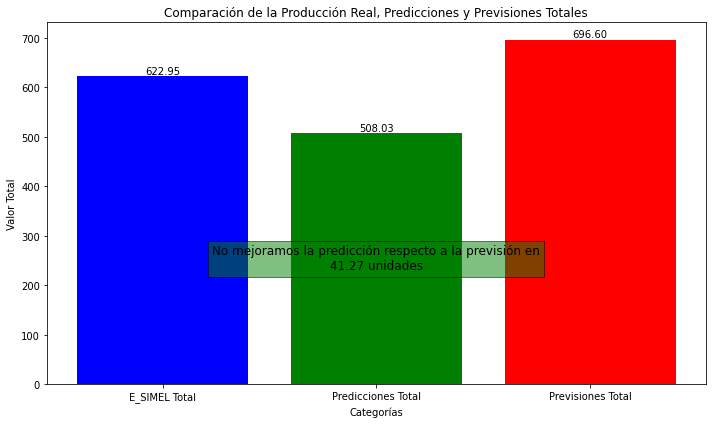

In [37]:
# Valores que cogemos para el gráfico

categorias = ['E_SIMEL Total', 'Predicciones Total', 'Previsiones Total']
valores = [suma_e_simel, sumas_totales_predicciones, sumas_previsiones]

# Creamos un gráfico de barras

plt.figure(figsize=(10, 6))
barra = plt.bar(categorias, valores, color=['blue', 'green', 'red'])

# Añadimos las etiqutas

for rect in barra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Título del gráfico y ponemos las etiquteas a cada barra
    
plt.title('Comparación de la Producción Real, Predicciones y Previsiones Totales')
plt.xlabel('Categorías')
plt.ylabel('Valor Total')


# Ubicamos el texto de la diferencia

pos_y = valores[1] / 2
pos_x = categorias[1]
plt.text(pos_x, pos_y, f'No mejoramos la predicción respecto a la previsión en\n{diferencia:.2f} unidades', ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='green', alpha=0.5))
plt.tight_layout()
plt.show()